# Предсказание ожидаемой продолжительности жизни в странах

In [115]:
import sys
# Добавим папку с корнем проекта в список системных директорий, чтобы Python видел путь к папке utils
sys.path.append('..')

In [116]:
from IPython.display import Markdown
import time
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import (
    BaggingRegressor, 
    AdaBoostRegressor,
    StackingRegressor,
)

from utils.constants import (
    F, 
    RANDOM_STATE,
)
from utils.helpers import get_exec_time
from utils.display_content import (
    display_fields_correlation,
)
from utils.prepare_data import (
    get_location_codes,
    get_location_time_series,
    get_location_by_code,
    get_train_test_data,
    get_data_with_smoothing_target_feature,
    get_integration_order,
    get_predictors,
    get_train_test_split,
    get_location_data,
    get_formatted_time_series,
)

%matplotlib inline

from warnings import simplefilter
simplefilter('ignore')

In [117]:
# Загрузим таблицу
data_source = pd.read_csv(
    '../data/cumulative_life_expectancy_prepared.csv'
)

data_source.head()

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ClusterKMeans,PositiveCoef,NegativeCoef,ImmunizationMean,LifeExpectancy
0,AFR,Africa,AGO,Angola,2000,34.56,0.01331,0.859921,30.5,0.028126,...,1.11,7.66,563.733796,16194869.0,5.027188,1,0.839586,0.837126,28.000000,49.37
1,AFR,Africa,AGO,Angola,2001,33.86,0.01310,0.799641,29.7,0.027503,...,2.05,13.35,533.586202,16747208.0,5.092250,1,0.839586,0.837126,43.333333,50.06
2,AFR,Africa,AGO,Angola,2002,32.51,0.01288,0.758272,29.4,0.027049,...,1.31,11.54,882.147847,17327699.0,5.157312,1,0.839586,0.837126,42.666667,51.06
3,AFR,Africa,AGO,Angola,2003,32.16,0.01265,0.676496,29.3,0.026962,...,1.47,14.55,992.698979,17943712.0,5.222375,1,0.839586,0.837126,37.000000,51.74
4,AFR,Africa,AGO,Angola,2004,32.24,0.01229,0.594192,29.0,0.026300,...,1.69,21.36,1266.210864,18600423.0,5.287437,1,0.839586,0.837126,36.000000,52.36


In [118]:
# Загрузим также таблицу с порядком интегрирования рядов стран
integration_order_data = pd.read_csv(
    '../data/integration_order.csv'
)

integration_order_data.head()

,SpatialDimValueCode,IntegrationOrder
0,AGO,1
1,BDI,1
2,BEN,1
3,BFA,1
4,BWA,1


## Выбор метрики MAE

Поскольку мы решаем задачу регрессии (предсказываем число), выберем в качестве метрики \
среднюю абсолютную ошибку для полученного прогноза — MAE (Mean Absolute Error),

$$ MAE = \frac{\sum_{i=1}^{n}\left | y_{i} - \hat{y_{i}} \right |}{n} $$

In [119]:
# Словарь для хранения метрик, полученных с помощью разных моделей
model_results = {}


def save_model_result(
    model_name: str, 
    mae_test: float,
    model_fit_time: str
) -> None:
    """Сохраняет значение метрики и время обучения для переданной модели

    Args:
        model_name (str): имя модели
        mae_test (float): метрика MAE для тестовой выборки
        model_fit_time (str): время обучения модели
    """
    model_results[model_name] = { 
        'MaeTest': mae_test, 'ModelFitTime': model_fit_time,
    }
    
    
def display_model_results(should_sorted: bool = False) -> None:
    """Выводит таблицу со значениями метрики MAE и временем обучения для разных моделей
    
    Args: 
        should_sorted (bool, optional): нужно ли сорртировать строки по возрастанию метрики
            По умолчанию False
    """
    display(Markdown('**Значения метрики MAE для разных моделей**'))
    
    model_results_data = pd.DataFrame(model_results).transpose()
    
    if (should_sorted):
        display(model_results_data.sort_values(by='MaeTest'))
    else:
        display(model_results_data)

## Разделение данных на обучающую и тестовую выборки

Поскольку данные продолжительности жизни для стран за 2000 - 2020 гг являются временными рядами \
и имеет смысл предсказание будущих значений, \
то в качестве тестовой выборки отделим последние 3 года, то есть с 2018 по 2020 гг.

In [120]:
# Разделим данные на тренировочные и тестовые
train_data_source, test_data_source = get_train_test_data(data_source)

display(train_data_source.head(3))
display(test_data_source.head(3))

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ClusterKMeans,PositiveCoef,NegativeCoef,ImmunizationMean,LifeExpectancy
0,AFR,Africa,AGO,Angola,2000,34.56,0.01331,0.859921,30.5,0.028126,...,1.11,7.66,563.733796,16194869.0,5.027188,1,0.839586,0.837126,28.000000,49.37
1,AFR,Africa,AGO,Angola,2001,33.86,0.01310,0.799641,29.7,0.027503,...,2.05,13.35,533.586202,16747208.0,5.092250,1,0.839586,0.837126,43.333333,50.06
2,AFR,Africa,AGO,Angola,2002,32.51,0.01288,0.758272,29.4,0.027049,...,1.31,11.54,882.147847,17327699.0,5.157312,1,0.839586,0.837126,42.666667,51.06


,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ClusterKMeans,PositiveCoef,NegativeCoef,ImmunizationMean,LifeExpectancy
18,AFR,Africa,AGO,Angola,2018,25.83,0.009380,0.233096,24.0,0.013602,...,1.10,35.75,2538.591391,31297155.0,6.377063,1,0.839586,0.837126,58.000000,62.27
19,AFR,Africa,AGO,Angola,2019,25.79,0.009200,0.227687,24.6,0.013479,...,1.12,29.33,2189.855714,32375632.0,6.488062,1,0.839586,0.837126,54.666667,62.49
20,AFR,Africa,AGO,Angola,2020,25.54,0.009377,0.221906,25.3,0.012816,...,1.70,29.04,1449.922867,33451132.0,6.599062,1,0.839586,0.837126,48.666667,62.65


Добавим столбец `SmoothingLifeExpectancy` со сглаженными значениями и прогнозом в тренировочные и тестовые данные.

In [121]:
# Начинаем замерять время выполнения
start = time.time()

train_data, test_data = get_data_with_smoothing_target_feature(
    train_data_source, test_data_source
)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

## Прогноз на основе экспоненциального сглаживания

Посмотрим, какое значение метрики даст уже добавленный признак `SmoothingLifeExpectancy`, \
полученный с помощью экспоненциального сглаживания.\
Его ведь уже можно считать предсказанием.

In [122]:
# Истинные значения тестовой выборки
y_test = test_data[F.LifeExpectancy.value]
# Сглаженные значения прогноза на 3 года
y_test_pred = test_data[F.SmoothingLifeExpectancy.value]

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)

# Запомним результаты модели
save_model_result(
    'ExponentialSmoothing',
    mae_test,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,ModelFitTime
ExponentialSmoothing,0.553576,00:00:01


То есть, в среднем полученный пока прогноз ошибается на 0.554 года.

## ARIMA

**ARIMA** расшифровывается как **Autoregressive Integrated Moving Average** \
(Авторегрессионное интегрированное скользящее среднее)\
И включает в себя 3 параметра:

- `p` — параметр авторегрессионной модели (`AR(p)`), \
количество авторегрессионных слагаемых, \
определяется по графику частичной автокорреляции;
- `q` — параметр скользящего среднего (`MA(q)`), \
количество слагаемых скользящего среднего шумовой компоненты, \
определяется по графику автокорреляции.
- `d` — порядок дифференцирования ряда.

Значение `d` определим по ранее созданной [здесь](../03_eda/09_stationarity.ipynb) таблице `integration_order.csv`\
с помощью функции `get_integration_order` из файла [prepare_data.py](../utils/prepare_data.py)

А значения `p` и `q` возьмем равными `1`, так как по графикам автокорреляции и частичной автокорреляции,\
построенными в файле [11_partial_autocorrelation.ipynb](../03_eda/11_partial_autocorrelation.ipynb)
полноценно закономерность на таком небольшом количестве данных мы не уловим.

In [123]:
# Коды всех стран
location_codes = get_location_codes(data_source)

# Таблица, в которую будем собирать данные прогнозов по странам
forecast_data = pd.DataFrame(
    columns=[F.SpatialDimValueCode.value, F.Period.value, F.LifeExpectancy.value]
)

# Начинаем замерять время выполнения
start = time.time()

# Посчитаем прогноз для каждой страны
for code in location_codes:
    # Временной ряд для тренировочных данных
    location_time_series_train = get_location_time_series(train_data, code) 
    # Временной ряд для тестовых данных
    location_time_series_test = get_location_time_series(test_data, code) 
    # Количество значений, которые нужно предсказать
    predict_length = len(location_time_series_test)
    # Порядок интегрирования ряда
    integration_order = get_integration_order(code)
    # Параметры модели
    p = 1
    q = 1
    d = integration_order
    # Создаем объект модели
    arima_model = ARIMA(location_time_series_train, order=(p, d, q))
    # Обучим модель
    arima_model_fit = arima_model.fit()
    # Получим прогноз на то же количество лет, которое содержится в тестовом временном ряду
    forecast = arima_model_fit.forecast(predict_length)
    # Соберем данные прогноза по стране в таблицу
    location_forecast_data = pd.DataFrame({
        F.SpatialDimValueCode.value: code,
        F.Period.value: forecast.index, 
        F.LifeExpectancy.value: forecast.values,
    })
    # Присоединим ее к общей таблице прогнозов
    forecast_data = pd.concat([forecast_data, location_forecast_data], ignore_index=True)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Поля для сортировки
sort_fields = [F.SpatialDimValueCode.value, F.Period.value]

# Истинные значения тестовой выборки
y_test = test_data.sort_values(by=sort_fields)[F.LifeExpectancy.value]
# Значения прогноза 
y_test_pred = forecast_data.sort_values(by=sort_fields)[F.LifeExpectancy.value]

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)

# Запомним результаты модели
save_model_result(
    'ARIMA',
    mae_test,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,ModelFitTime
ExponentialSmoothing,0.553576,00:00:01
ARIMA,0.628497,00:00:11


Попробуем воспользоваться библиотекой `pmdarima` для подбора параметров модели `ARIMA`.

In [124]:
# Таблица, в которую будем собирать данные прогнозов по странам
forecast_data = pd.DataFrame(
    columns=[F.SpatialDimValueCode.value, F.Period.value, F.LifeExpectancy.value]
)

# Начинаем замерять время выполнения
start = time.time()

# Посчитаем прогноз для каждой страны
for code in location_codes:
    # Временной ряд для тренировочных данных
    location_time_series_train = get_location_time_series(train_data, code) 
    # Временной ряд для тестовых данных
    location_time_series_test = get_location_time_series(test_data, code) 
    # Количество значений, которые нужно предсказать
    predict_length = len(location_time_series_test)
    
    # Инициализируем объект pmdarima для подбора параметров
    pm_auto_arima_model = pm.auto_arima(
        location_time_series_train,
        start_p=1, start_q=1, # начальные значения для p и q
        max_p=2, max_q=2, # максимальные значения для p и q
        max_d=3, # максимальное значение d
        seasonal=False, # сезонности у нас нет
        test='kpss', # тест возьмем тот же, которым ранее определяли стационарность ряда
    )
    # Получим прогноз
    forecast = pm_auto_arima_model.fit_predict(location_time_series_train, n_periods=predict_length)
    
    # Соберем данные прогноза по стране в таблицу
    location_forecast_data = pd.DataFrame({
        F.SpatialDimValueCode.value: code,
        F.Period.value: forecast.index, 
        F.LifeExpectancy.value: forecast.values,
    })
    # Присоединим ее к общей таблице прогнозов
    forecast_data = pd.concat([forecast_data, location_forecast_data], ignore_index=True)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Истинные значения тестовой выборки
y_test = test_data.sort_values(by=sort_fields)[F.LifeExpectancy.value]
# Значения прогноза 
y_test_pred = forecast_data.sort_values(by=sort_fields)[F.LifeExpectancy.value]

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)

# Запомним результаты модели
save_model_result(
    'ARIMA with pmdarima',
    mae_test,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,ModelFitTime
ExponentialSmoothing,0.553576,00:00:01
ARIMA,0.628497,00:00:11
ARIMA with pmdarima,0.682415,00:01:09


Метрика не улучшилась, а время выполнения дольше, чем для экспоненциального сглаживания.\
Скорее всего, модель ARIMA подходит хуже из-за небольшого количества данных в рядах.

## ARIMAX

Для предсказания значений временного ряда с экзогенными переменными используем модель `ARIMAX`.\
Модель `SARIMAX` из библиотеки `statsmodels` без использования сезонной составляющей даст в итоге модель `ARIMAX`.\
То есть, мы не будем указывать параметр `seasonal_order` для модели `SARIMAX`.

In [125]:
# Таблица, в которую будем собирать данные прогнозов по странам
forecast_data = pd.DataFrame(
    columns=[F.SpatialDimValueCode.value, F.Period.value, F.LifeExpectancy.value]
)

# Первый и последний год в исходной таблице
year_start = data_source[F.Period.value].min()
year_end = data_source[F.Period.value].max()

# Начинаем замерять время выполнения
start = time.time()

# Составим прогноз для каждой страны
for code in location_codes:
    # Название страны
    location = get_location_by_code(code)    
    # Данные страны
    location_data = get_location_data(data_source, code)
    
    # Получаем тренировочные и тестовые данные для страны
    X_train, X_test, y_train, y_test = get_train_test_split(
        location_data,
        should_include_time_feature = False,
    )
    
    # Длина ряда с пронозом
    predict_length = len(y_test)
    
    # Порядок интегрирования ряда
    integration_order = get_integration_order(code)
    # Параметры order
    p = 1
    q = 1
    d = integration_order
    
    # Объект модели SARIMAX
    sarimax_model = SARIMAX(
        y_train, # Временной ряд
        X_train, # Экзогенные параметры
        order=(p, d, q),
        time_varying_regression=True,
        mle_regression=False,
    )
    
    # Обучаем модель
    sarimax_model_fit = sarimax_model.fit()
    
    # Делаем предсказание
    forecast = sarimax_model_fit.forecast(
        predict_length, # количество прогнозов
        exog=X_test, # экзогенные параметры для тестовой выборки
    )
    
    # Переводим массив данных во временной ряд с индексом datetime
    test_year_start = year_end - predict_length
    time_series_forecast = get_formatted_time_series(forecast, test_year_start)
    
    # Соберем данные прогноза по стране в таблицу
    location_forecast_data = pd.DataFrame({
        F.SpatialDimValueCode.value: code,
        F.Period.value: time_series_forecast.index, 
        F.LifeExpectancy.value: forecast,
    })
    # Присоединим ее к общей таблице прогнозов
    forecast_data = pd.concat([forecast_data, location_forecast_data], ignore_index=True)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Истинные значения тестовой выборки
y_test = test_data.sort_values(by=sort_fields)[F.LifeExpectancy.value].values
# Значения прогноза
y_test_pred = forecast_data.sort_values(by=sort_fields)[F.LifeExpectancy.value].values

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)

# Запомним результаты модели
save_model_result(
    'ARIMAX',
    mae_test,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,ModelFitTime
ExponentialSmoothing,0.553576,00:00:01
ARIMA,0.628497,00:00:11
ARIMA with pmdarima,0.682415,00:01:09
ARIMAX,1.631299,00:00:07


Метрика за счет использования экзогенных параметров не улучшилась.\
Скорее всего причина в малом количестве данных для обучения по каждой стране.\
Попробуем использовать линейную регрессию.

## Подготовка данных для модели линейной регрессии

Перед использованием линейной регрессии удалим некоторые мультиколлинеарные признаки и признаки, имеющие низкую корреляцию с целевой переменной и масштабируем данные.\
Отбор признаков реализован вручную путем отсеивания мультиколлинеарных признаков, которые имеют меньшую корреляцию с целевой переменной.

In [126]:
def extract_optimal_features(data_source: pd.DataFrame) -> pd.DataFrame:
    """Оставляет в данных оптимальные признаки

    Args:
        data_source (pd.DataFrame): исходные данные

    Returns:
        pd.DataFrame: обработанные данные
    """
    # Копируем таблицу, чтобы не мутировать исходные данные
    data = data_source.copy()
    
    # Получим список предикторов (список полей для предсказания не включает данные о смертности)
    predictors = get_predictors(data)
    # Оставим только предикторы и целевую переменную
    data = data[predictors + [F.LifeExpectancy.value]]    
    
    # Поля для удаления
    columns_to_drop = [
        F.HepatitisBImmunization.value,        
        F.Population.value,
                
        F.BmiChildOverweight2.value,
        F.BmiTeenagerOverweight1.value,
        F.BmiTeenagerOverweight2.value,
        F.BmiAdultOverweight25.value,
        F.BmiAdultOverweight30.value,
        
        F.BmiChildThinness.value,
        F.BmiTeenagerThinness.value,    
        F.BmiAdultUnderweight.value,
        
        F.DrinkingWater.value,
        
        F.HealthCareCostsPerCapita.value,
        F.HealthCareCosts.value,
        F.HealthCareCostsGdp.value,
        
        F.PositiveCoef.value,
        F.ClusterKMeans.value,
        
        F.Period.value,        
        F.Schooling.value,
        
        F.AlcoholСonsumption.value,        
        F.BmiChildOverweight1.value,
    ]
    
    data.drop(columns=columns_to_drop, inplace=True)
    
    return data

Построим матрицу корреляции.

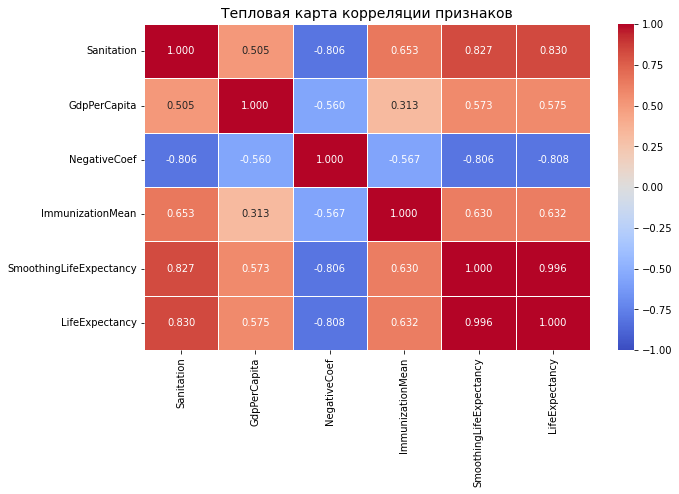

Посмотрим на пары признаков с коэффициентом корреляции больше, чем `0.7`

[(['Sanitation', 'NegativeCoef'], -0.81),
 (['Sanitation', 'SmoothingLifeExpectancy'], 0.83),
 (['Sanitation', 'LifeExpectancy'], 0.83),
 (['NegativeCoef', 'SmoothingLifeExpectancy'], -0.81),
 (['NegativeCoef', 'LifeExpectancy'], -0.81),
 (['SmoothingLifeExpectancy', 'LifeExpectancy'], 1.0)]

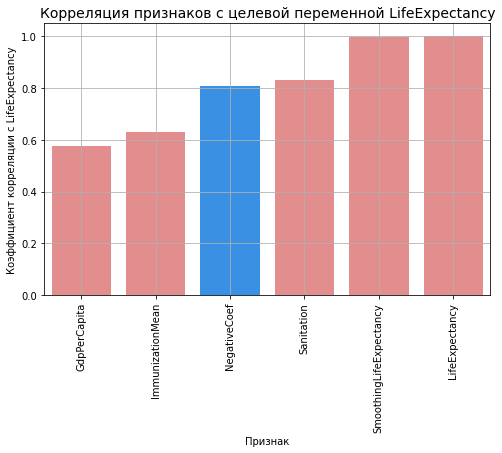

In [127]:
# Оставим в тренировочных данных оптимальные признаки
train_data_optimal = extract_optimal_features(train_data)

# Посмотрим на их корреляцию друг с другом и с целевой переменной
display_fields_correlation(
    train_data_optimal,
    matrix_figsize=(10, 6),
    barplot_figsize=(8, 5)
)

In [128]:
# Оставим в тренировочных и тестовых данных оптимальные признаки
train_data = extract_optimal_features(train_data)
test_data = extract_optimal_features(test_data)

# Разделим предикторы и таргет
X_train = train_data.drop(columns=[F.LifeExpectancy.value])
X_test = test_data.drop(columns=[F.LifeExpectancy.value])

y_train = train_data[F.LifeExpectancy.value]
y_test = test_data[F.LifeExpectancy.value]

# Перед масштабированием данных сохраним имена столбцов и индексы
columns = list(X_train.columns)
index_train = X_train.index
index_test = X_test.index

# Инициализируем нормализатор MinMaxScaler
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train)

# Масштабируем данные
X_train = mm_scaler.transform(X_train)
# Добавим имена столбцов и индексы, которые потерялись при преобразовании
X_train = pd.DataFrame(X_train, columns=columns, index=index_train)

X_test = mm_scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=columns, index=index_test)

Посмотрим на характеристики распределения предикторов.

In [129]:
X_test.describe()

,Sanitation,GdpPerCapita,NegativeCoef,ImmunizationMean,SmoothingLifeExpectancy
count,543.000000,543.000000,543.000000,543.000000,543.000000
mean,0.753130,0.111969,0.647598,0.840328,0.756278
std,0.284264,0.158217,0.195836,0.171542,0.152213
min,0.057196,0.000813,0.000000,0.197368,0.318538
25%,0.507870,0.015352,0.504412,0.771930,0.642568
50%,0.888386,0.044275,0.630020,0.903509,0.782115
75%,0.978809,0.136843,0.844239,0.964912,0.863595
max,1.000000,0.945186,1.000000,1.000000,1.004312


In [130]:
X_test.describe()

,Sanitation,GdpPerCapita,NegativeCoef,ImmunizationMean,SmoothingLifeExpectancy
count,543.000000,543.000000,543.000000,543.000000,543.000000
mean,0.753130,0.111969,0.647598,0.840328,0.756278
std,0.284264,0.158217,0.195836,0.171542,0.152213
min,0.057196,0.000813,0.000000,0.197368,0.318538
25%,0.507870,0.015352,0.504412,0.771930,0.642568
50%,0.888386,0.044275,0.630020,0.903509,0.782115
75%,0.978809,0.136843,0.844239,0.964912,0.863595
max,1.000000,0.945186,1.000000,1.000000,1.004312


Остались необходимые масштабированные признаки.

## Линейная регрессия

Теперь применим модель линейной регрессии.

In [131]:
# Начинаем замерять время выполнения
start = time.time()

# Создаём объект класса LinearRegression
linear_regression_model = LinearRegression()

# Обучаем модель
linear_regression_model.fit(X_train, y_train) 

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Получаем предсказание
y_test_pred = linear_regression_model.predict(X_test)

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)

# Запомним результаты модели
save_model_result(
    'LinearRegression',
    mae_test,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,ModelFitTime
ExponentialSmoothing,0.553576,00:00:01
ARIMA,0.628497,00:00:11
ARIMA with pmdarima,0.682415,00:01:09
ARIMAX,1.631299,00:00:07
LinearRegression,0.550498,00:00:00


Нам удалось улучшить метрику по сравнению с полученной путем экспоненциального сглаживания.

In [132]:
print('Свободный коэффициент линейной регрессии регрессии:')
print(linear_regression_model.intercept_)

print()

print('Коэффициенты линейной регрессии:')
print(linear_regression_model.coef_)

Свободный коэффициент линейной регрессии регрессии:
36.99748759982112

Коэффициенты линейной регрессии:
[ 0.33812997  0.28553169 -0.33607295  0.21869841 46.6780749 ]


Коэффициенты линейной регрессии не очень большие и не очень маленькие.\
Что говорит об устойчивости модели.

> Практика показала, что модели, основанные на деревьях решений, \
показывают на этих данных не очень хорошие результаты. \
И не сильно улучшают метрику по сравнению с результатом экспоненциального сглаживания. \
Поэтому сосредоточимся на моделях линейной регрессии, которые все же дают улучшение метрики.

## Полиномиальная регрессия 2-й степени

In [133]:
# Создаём генератор полиномиальных признаков
polynomial_features_generator2 = PolynomialFeatures(degree=2, include_bias=False)
# Обучаем его
polynomial_features_generator2.fit(X_train)

# Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly2 = polynomial_features_generator2.transform(X_train)
# Генерируем полиномиальные признаки для тестовой выборки
X_test_poly2 = polynomial_features_generator2.transform(X_test)

# Посмотрим на количество созданных признаков
print('Количество созданных признаков: ', X_train_poly2.shape[1])

Количество созданных признаков:  20


In [134]:
# Начинаем замерять время выполнения
start = time.time()

# Создаём объект класса LinearRegression
linear_regression_poly2_model = LinearRegression()

# Обучаем модель
linear_regression_poly2_model.fit(X_train_poly2, y_train)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Делаем предсказание для тестовой выборки
y_test_pred = linear_regression_poly2_model.predict(X_test_poly2)

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)

# Запомним результаты модели
save_model_result(
    'LinearRegression poly 2',
    mae_test,
    exec_time,
)

# Выведем результаты
display_model_results()


**Значения метрики MAE для разных моделей**

,MaeTest,ModelFitTime
ExponentialSmoothing,0.553576,00:00:01
ARIMA,0.628497,00:00:11
ARIMA with pmdarima,0.682415,00:01:09
ARIMAX,1.631299,00:00:07
LinearRegression,0.550498,00:00:00
LinearRegression poly 2,0.553243,00:00:00


Метрика не улучшилась.

In [135]:
print('Свободный коэффициент линейной регрессии регрессии:')
print(linear_regression_poly2_model.intercept_)

print()

print('Коэффициенты линейной регрессии:')
print(linear_regression_poly2_model.coef_)

Свободный коэффициент линейной регрессии регрессии:
47.40336703678589

Коэффициенты линейной регрессии:
[  4.85691674   9.98316598 -10.79115062   0.09647674  21.43159281
  -0.02299709  -1.07719983  -3.86418403  -0.86385832  -2.07488889
  -0.425274    -3.36812668  -2.34512351  -5.18609226   1.81144256
  -0.15803555  15.82126086  -1.42801325   4.41925674   9.70593271]


Коэффициенты не очень большие и не очень маленькие. \
Можно предположить, что модель устойчива.

## Полиномиальная регрессия 2-й степени с L1 регуляризацией

In [136]:
# Начинаем замерять время выполнения
start = time.time()

# Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_poly2_model = Lasso(alpha=0.0003, max_iter=10000, random_state=RANDOM_STATE)

# Обучаем модель
lasso_poly2_model.fit(X_train_poly2, y_train)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Делаем предсказание для тестовой выборки
y_test_pred = lasso_poly2_model.predict(X_test_poly2)

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)

# Запомним результаты модели
save_model_result(
    'Lasso poly 2',
    mae_test,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,ModelFitTime
ExponentialSmoothing,0.553576,00:00:01
ARIMA,0.628497,00:00:11
ARIMA with pmdarima,0.682415,00:01:09
ARIMAX,1.631299,00:00:07
LinearRegression,0.550498,00:00:00
LinearRegression poly 2,0.553243,00:00:00
Lasso poly 2,0.549719,00:00:00


Метрика немного улучшилась по сравнению с линейной регрессией.\
Пока это лучшая из полученных метрик.

In [137]:
print('Свободный коэффициент линейной регрессии регрессии:')
print(lasso_poly2_model.intercept_)

print()

print('Коэффициенты линейной регрессии:')
print(lasso_poly2_model.coef_)

Свободный коэффициент линейной регрессии регрессии:
43.785757501720326

Коэффициенты линейной регрессии:
[ 1.09430797e+00  1.11198160e-01 -7.01989517e+00  1.99726273e-01
  3.24658669e+01  0.00000000e+00  0.00000000e+00 -8.26606234e-01
 -1.51395975e-02 -6.13715408e-01 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.13756866e+00  0.00000000e+00
  8.11610236e+00 -7.39147785e-01  1.62164078e+00  6.21844252e+00]


Коэффициенты опять же не слишком большие и не слишком маленкие.\
Что говорит об устойчивости модели.\
Некоторые коэффициенты обнулились, что характерно для L1-регуляризации.

## Полиномиальная регрессия 3-й степени с L1 регуляризацией

In [138]:
# Создаём генератор полиномиальных признаков
polynomial_features_generator3 = PolynomialFeatures(degree=3, include_bias=False)
# Обучаем его
polynomial_features_generator3.fit(X_train)

# Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly3 = polynomial_features_generator3.transform(X_train)

# Генерируем полиномиальные признаки для тестовой выборки
X_test_poly3 = polynomial_features_generator3.transform(X_test)

# Посмотрим на количество созданных признаков
print('Количество созданных признаков: ', X_train_poly3.shape[1])

Количество созданных признаков:  55


In [139]:
# Начинаем замерять время выполнения
start = time.time()

# Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_poly3_model = Lasso(alpha=0.0003, max_iter=10000, random_state=RANDOM_STATE)

# Обучаем модель
lasso_poly3_model.fit(X_train_poly3, y_train)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Делаем предсказание для тестовой выборки
y_test_pred = lasso_poly3_model.predict(X_test_poly3)

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)

# Запомним результаты модели
save_model_result(
    'Lasso poly 3',
    mae_test,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,ModelFitTime
ExponentialSmoothing,0.553576,00:00:01
ARIMA,0.628497,00:00:11
ARIMA with pmdarima,0.682415,00:01:09
ARIMAX,1.631299,00:00:07
LinearRegression,0.550498,00:00:00
LinearRegression poly 2,0.553243,00:00:00
Lasso poly 2,0.549719,00:00:00
Lasso poly 3,0.546849,00:00:00


Немного улучшили метрику по сравнению с предыдущей моделью.

In [140]:
print('Свободный коэффициент линейной регрессии регрессии:')
print(lasso_poly3_model.intercept_)

print()

print('Коэффициенты линейной регрессии:')
print(lasso_poly3_model.coef_)

Свободный коэффициент линейной регрессии регрессии:
41.90058109486991

Коэффициенты линейной регрессии:
[ 1.06819524  0.19647873 -0.         -0.         30.34774221  0.37007157
  0.         -0.          0.          0.         -0.          0.
  0.          0.         -3.47621608 -0.          0.         -0.
  2.72792918 12.76813103  0.          0.         -0.         -0.
 -0.         -0.          0.          0.          0.         -0.60579634
 -0.87371824 -0.         -0.         -0.         -1.32553209 -0.
 -0.         -0.05297178 -0.          0.          0.         -0.
 -0.         -0.         -0.          0.         -0.          6.31519242
 -0.39594167  0.          0.         -0.504007    0.         -0.
 -2.97916752]


Коэффициенты опять же не слишком большие и не слишком маленкие.\
Что говорит об устойчивости модели.\
Некоторые коэффициенты обнулились, что характерно для L1-регуляризации.

## Бэггинг

Попробуем использовать бэггинг для уже испробованных выше моделей.

### Бэггинг линейных регрессий

In [141]:
# Начинаем замерять время выполнения
start = time.time()

# Создаем модель
bg_model = BaggingRegressor(
    estimator=LinearRegression(),
    n_estimators=4500,
    random_state=RANDOM_STATE,
)
# Обучаем
bg_model.fit(X_train, y_train)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Делаем предсказание для тестовой выборки
y_test_pred = bg_model.predict(X_test)

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)

# Запомним результаты модели
save_model_result(
    'Bagging LinearRegression',
    mae_test,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,ModelFitTime
ExponentialSmoothing,0.553576,00:00:01
ARIMA,0.628497,00:00:11
ARIMA with pmdarima,0.682415,00:01:09
ARIMAX,1.631299,00:00:07
LinearRegression,0.550498,00:00:00
LinearRegression poly 2,0.553243,00:00:00
Lasso poly 2,0.549719,00:00:00
Lasso poly 3,0.546849,00:00:00
Bagging LinearRegression,0.55053,00:00:06


Метрика сравнима с обычной линейной регрессией.

### Бэггинг полиномиальных регрессий 2-й степени с L1-регуляризацией

In [142]:
# Начинаем замерять время выполнения
start = time.time()

# Создаем модель
bg_model = BaggingRegressor(
    estimator=Lasso(alpha=0.0003, max_iter=10000, random_state=RANDOM_STATE),
    n_estimators=1500,
    random_state=RANDOM_STATE,
)

# Обучаем
bg_model.fit(X_train_poly2, y_train)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Делаем предсказание для тестовой выборки
y_test_pred = bg_model.predict(X_test_poly2)

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)

# Запомним результаты модели
save_model_result(
    'Bagging Lasso poly 2',
    mae_test,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,ModelFitTime
ExponentialSmoothing,0.553576,00:00:01
ARIMA,0.628497,00:00:11
ARIMA with pmdarima,0.682415,00:01:09
ARIMAX,1.631299,00:00:07
LinearRegression,0.550498,00:00:00
LinearRegression poly 2,0.553243,00:00:00
Lasso poly 2,0.549719,00:00:00
Lasso poly 3,0.546849,00:00:00
Bagging LinearRegression,0.55053,00:00:06
Bagging Lasso poly 2,0.548879,00:01:44


Метрика немного лучше, чем у просто полиномиальной регрессии 2-й степени с L1-регуляризацией.

## Бустинг

Применим адаптивный бустинг с помощью  `AdaBoostRegressor` на основе построенных ранее моделей.

### Бустинг линейных регрессий

In [143]:
# Начинаем замерять время выполнения
start = time.time()

# Создаем модель
abr_model = AdaBoostRegressor(
    base_estimator=LinearRegression(),
    learning_rate=0.0002, 
    random_state=RANDOM_STATE
)
# Обучаем
abr_model.fit(X_train, y_train)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Делаем предсказание для тестовой выборки
y_test_pred = abr_model.predict(X_test)

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)

# Запомним результаты модели
save_model_result(
    'AdaBoost LinearRegression',
    mae_test,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,ModelFitTime
ExponentialSmoothing,0.553576,00:00:01
ARIMA,0.628497,00:00:11
ARIMA with pmdarima,0.682415,00:01:09
ARIMAX,1.631299,00:00:07
LinearRegression,0.550498,00:00:00
LinearRegression poly 2,0.553243,00:00:00
Lasso poly 2,0.549719,00:00:00
Lasso poly 3,0.546849,00:00:00
Bagging LinearRegression,0.55053,00:00:06
Bagging Lasso poly 2,0.548879,00:01:44


Метрика сравнима с бэггингом линейных регрессий.

### Бустинг полиномиальных регрессий 2-й степени с L1-регуляризацией

In [144]:
# Начинаем замерять время выполнения
start = time.time()

# Создаем модель
abr_model = AdaBoostRegressor(
    base_estimator=Lasso(alpha=0.0003, max_iter=10000, random_state=RANDOM_STATE),
    learning_rate=0.0002, 
    random_state=RANDOM_STATE
)
# Обучаем
abr_model.fit(X_train_poly2, y_train)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Делаем предсказание для тестовой выборки
y_test_pred = abr_model.predict(X_test_poly2)

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)

# Запомним результаты модели
save_model_result(
    'AdaBoost Lasso poly 2',
    mae_test,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,ModelFitTime
ExponentialSmoothing,0.553576,00:00:01
ARIMA,0.628497,00:00:11
ARIMA with pmdarima,0.682415,00:01:09
ARIMAX,1.631299,00:00:07
LinearRegression,0.550498,00:00:00
LinearRegression poly 2,0.553243,00:00:00
Lasso poly 2,0.549719,00:00:00
Lasso poly 3,0.546849,00:00:00
Bagging LinearRegression,0.55053,00:00:06
Bagging Lasso poly 2,0.548879,00:01:44


Метрика сравнима с бэггингом полиномиальных регрессий 2-й степени с L1-регуляризацией.\
Но по времени считается намного быстрее.

### Бустинг полиномиальных регрессий 3-й степени с L1-регуляризацией

In [145]:
# Начинаем замерять время выполнения
start = time.time()

# Создаем модель
abr_model = AdaBoostRegressor(
    base_estimator=Lasso(alpha=0.0003, max_iter=10000, random_state=RANDOM_STATE),
    learning_rate=0.0003, # 0.0003
    random_state=RANDOM_STATE
)
# Обучаем
abr_model.fit(X_train_poly3, y_train)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Делаем предсказание для тестовой выборки
y_test_pred = abr_model.predict(X_test_poly3)

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)

# Запомним результаты модели
save_model_result(
    'AdaBoost Lasso poly 3',
    mae_test,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,ModelFitTime
ExponentialSmoothing,0.553576,00:00:01
ARIMA,0.628497,00:00:11
ARIMA with pmdarima,0.682415,00:01:09
ARIMAX,1.631299,00:00:07
LinearRegression,0.550498,00:00:00
LinearRegression poly 2,0.553243,00:00:00
Lasso poly 2,0.549719,00:00:00
Lasso poly 3,0.546849,00:00:00
Bagging LinearRegression,0.55053,00:00:06
Bagging Lasso poly 2,0.548879,00:01:44


Пока данная метрика лучшая при приемлемом времени обучения.

## Стекинг

Применим стекинг на основе лучших из полученных моделей.

In [146]:
# Отсортируем модели по полученной метрике
display_model_results(True)

**Значения метрики MAE для разных моделей**

,MaeTest,ModelFitTime
AdaBoost Lasso poly 3,0.54606,00:00:20
Lasso poly 3,0.546849,00:00:00
Bagging Lasso poly 2,0.548879,00:01:44
AdaBoost Lasso poly 2,0.549271,00:00:03
Lasso poly 2,0.549719,00:00:00
AdaBoost LinearRegression,0.550268,00:00:00
LinearRegression,0.550498,00:00:00
Bagging LinearRegression,0.55053,00:00:06
LinearRegression poly 2,0.553243,00:00:00
ExponentialSmoothing,0.553576,00:00:01


Возьмем модели, в которых использовали полиномиальные признаки 3-й степени.\
Их две - это адаптивный бустинг на основе полиномиальной регрессии 3-й степени с L1-регуляризацией\
и сама полиномиальная регрессия 3-й степени с L1-регуляризацией.\
Бэггинг с полиномом 3-й степени считается около 20 минут  и не дает значимого прироста, поэтому не будем его брать.

In [147]:
# Начинаем замерять время выполнения
start = time.time()

abr_model = AdaBoostRegressor(
    base_estimator=Lasso(alpha=0.0003, max_iter=10000, random_state=RANDOM_STATE),
    learning_rate=0.0002, 
    random_state=RANDOM_STATE
)
lasso_poly3_model = Lasso(alpha=0.0003, max_iter=10000, random_state=RANDOM_STATE)

estimators = [
    ('lasso_poly3_model', lasso_poly3_model),
    ('abr_model', abr_model)
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

stacking_model.fit(X_train_poly3, y_train)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Делаем предсказание для тестовой выборки
y_test_pred = stacking_model.predict(X_test_poly3)

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)

# Запомним результаты модели
save_model_result(
    'Stacking poly 3',
    mae_test,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,ModelFitTime
ExponentialSmoothing,0.553576,00:00:01
ARIMA,0.628497,00:00:11
ARIMA with pmdarima,0.682415,00:01:09
ARIMAX,1.631299,00:00:07
LinearRegression,0.550498,00:00:00
LinearRegression poly 2,0.553243,00:00:00
Lasso poly 2,0.549719,00:00:00
Lasso poly 3,0.546849,00:00:00
Bagging LinearRegression,0.55053,00:00:06
Bagging Lasso poly 2,0.548879,00:01:44


Метрика не стала лучше, чем у моделей, на которых основан стекинг.

> Остановимся на модели адаптивного бустинга на основе полиномиальной регрессии 3-й степени с L1-регуляризацией. \
При приемлемом времени обучения 20 секунд она выдает лучшую метрику MAE = 0.54606 .